# importing the Libraries 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Importing the data and Data Wrangling

In [41]:
bike_master = pd.read_csv('bike_full.csv', dtype={5: str, 7: str})  # Convert both columns to strings


# Data Cleaning

In [42]:
bike_master_clean = bike_master.copy()

# Convert datetime columns
bike_master_clean['started_at'] = pd.to_datetime(bike_master_clean['started_at'])
bike_master_clean['ended_at'] = pd.to_datetime(bike_master_clean['ended_at'])

# Convert category columns
category_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
for col in category_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('category')

# Convert string columns (IDs)
string_columns = ['ride_id', 'start_station_id', 'end_station_id']
for col in string_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('string')

In [43]:
#finding unique values for few columns
bike_master_clean[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name       860
end_station_name         865
start_station_id        1321
end_station_id          1338
start_lat             570110
dtype: int64

In [44]:
#create a new column for month year
bike_master_clean['month_year'] = bike_master_clean['started_at'].dt.to_period('M')

#create a new column for year
bike_master_clean['year'] = bike_master_clean['started_at'].dt.year

#create a new dataframe for the month june 2023 to december 2023
bike_master_clean_2023 = bike_master_clean[(bike_master_clean['year'] == 2023)]

row_count = len(bike_master_clean_2023)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 4467334


In [45]:
# Function to categorize stations
def categorize_station_location(lat, lng):
    regions = {
        'Washington DC': {'lat': (38.8, 39.0), 'lng': (-77.12, -76.9)},
        'Arlington': {'lat': (38.8, 38.93), 'lng': (-77.17, -77.03)},
        'Alexandria': {'lat': (38.77, 38.85), 'lng': (-77.15, -77.03)},
        'Montgomery County': {'lat': (38.95, 39.2), 'lng': (-77.3, -76.9)},
        "Prince George's County": {'lat': (38.8, 39.1), 'lng': (-76.95, -76.7)},
        'Fairfax County': {'lat': (38.7, 39.0), 'lng': (-77.4, -77.15)}
    }
    
    for region, bounds in regions.items():
        if (bounds['lat'][0] <= lat <= bounds['lat'][1] and 
            bounds['lng'][0] <= lng <= bounds['lng'][1]):
            return region
    return 'Other'

# Apply function to classify each start station
bike_master_clean_2023.loc[:, 'region'] = bike_master_clean_2023.apply(
    lambda row: categorize_station_location(row['start_lat'], row['start_lng']),
    axis=1
)

/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_2778/1524768239.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_master_clean_2023.loc[:, 'region'] = bike_master_clean_2023.apply(


In [46]:
#convert the region column to category
bike_master_clean_2023['region'] = bike_master_clean_2023['region'].astype('category')

/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_2778/427240928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_master_clean_2023['region'] = bike_master_clean_2023['region'].astype('category')


# EDA and Plotting 

In [47]:
#find missing null values
print(bike_master_clean_2023.isnull().sum())

#drop missing values
bike_master_clean_2023 = bike_master_clean_2023.dropna()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    406630
start_station_id      406630
end_station_name      432484
end_station_id        432484
start_lat                  0
start_lng                  0
end_lat                 5945
end_lng                 5945
member_casual              0
month_year                 0
year                       0
region                     0
dtype: int64


In [48]:
bike_master_clean_2023.isnull().sum()
bike_master_clean_2023.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3864783 entries, 6226664 to 10693995
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    string        
 6   end_station_name    category      
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  month_year          period[M]     
 14  year                int32         
 15  region              category      
dtypes: category(5), datetime64[ns](2), float64(4), int32(1), period[M](1), string(3)
memory usage: 365.0 MB


# ML for Full Data Set

## Simple Model - Random Forest

In [49]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Extract basic features
bike_master_clean_2023['month'] = bike_master_clean_2023['started_at'].dt.month
bike_master_clean_2023['day_of_week'] = bike_master_clean_2023['started_at'].dt.dayofweek
bike_master_clean_2023['hour'] = bike_master_clean_2023['started_at'].dt.hour

# Group by month, rideable_type, and start_station_name to get ride counts
# Include 'day_of_week' and 'hour' in the groupby or aggregate them
grouped = (bike_master_clean_2023.groupby(['month', 'rideable_type', 'start_station_name', 'day_of_week', 'hour'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Define features and target
X = grouped[['month', 'day_of_week', 'hour', 'rideable_type']]  # Use 'rideable_type' as a feature
y = grouped['ride_count']

# Convert categorical 'rideable_type' to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['rideable_type'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Display Actual vs Predicted Values
comparison_df = pd.DataFrame({
    'Actual Rides': y_test.values,
    'Predicted Rides': y_pred
})

print(comparison_df.head())

# Predict future rides (using the same dataset for demonstration)
grouped['predicted_rides'] = model.predict(X)

# Get top 20 stations with the highest predicted rides
top_20_predicted = (grouped.sort_values(['month', 'predicted_rides'], ascending=[True, False])
                                .groupby(['month'], observed=True)
                                .head(20)
                                .reset_index(drop=True))

print(top_20_predicted.head())

Mean Squared Error (MSE): 23.38472216941331
R^2 Score: 0.16295080936722306
Mean Absolute Error (MAE): 2.8598333162504006
   Actual Rides  Predicted Rides
0             4         4.577129
1             1         3.972590
2             5         6.161623
3             9         5.710982
4            38         7.986637
   month rideable_type   start_station_name  day_of_week  hour  ride_count  \
0      1  classic_bike       10th & E St NW            1    17          19   
1      1  classic_bike       10th & G St NW            1    17           4   
2      1  classic_bike       10th & H St NE            1    17           5   
3      1  classic_bike       10th & K St NW            1    17          26   
4      1  classic_bike  10th & Monroe St NE            1    17           5   

   predicted_rides  
0         9.105978  
1         9.105978  
2         9.105978  
3         9.105978  
4         9.105978  


## RandomForest vs Polynominal with additional Features ( season etc)

In [ ]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Extract basic time-based features
bike_master_clean_2023['month'] = bike_master_clean_2023['started_at'].dt.month
bike_master_clean_2023['day_of_week'] = bike_master_clean_2023['started_at'].dt.dayofweek
bike_master_clean_2023['hour'] = bike_master_clean_2023['started_at'].dt.hour

# Add Weekend vs. Weekday Feature
bike_master_clean_2023['is_weekend'] = bike_master_clean_2023['day_of_week'].isin([5, 6]).astype(int)

# Define seasonality function
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

# Apply season feature
bike_master_clean_2023['season'] = bike_master_clean_2023['month'].apply(get_season)

# Group by month, rideable_type, start_station_name, day_of_week, hour, is_weekend, and season to get ride counts
grouped = (bike_master_clean_2023.groupby(['month', 'rideable_type', 'start_station_name', 'day_of_week', 'hour', 'is_weekend', 'season'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Define features and target
X1 = grouped[['month', 'day_of_week', 'hour', 'is_weekend', 'season', 'rideable_type']]
y1 = grouped['ride_count']

# Convert categorical variables using one-hot encoding
X1 = pd.get_dummies(X1, columns=['season', 'rideable_type'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_train_pred = rf_model.predict(X_train)
y_rf_test_pred = rf_model.predict(X_test)

# Polynomial Regression Model
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_poly_train_pred = poly_model.predict(X_train)
y_poly_test_pred = poly_model.predict(X_test)

# Evaluation - Random Forest
rf_mse_train = mean_squared_error(y_train, y_rf_train_pred)
rf_r2_train = r2_score(y_train, y_rf_train_pred)
rf_mae_train = mean_absolute_error(y_train, y_rf_train_pred)

rf_mse_test = mean_squared_error(y_test, y_rf_test_pred)
rf_r2_test = r2_score(y_test, y_rf_test_pred)
rf_mae_test = mean_absolute_error(y_test, y_rf_test_pred)

print("Random Forest - Training Set Performance:")
print(f"MSE: {rf_mse_train}, R²: {rf_r2_train}, MAE: {rf_mae_train}")

print("\nRandom Forest - Test Set Performance:")
print(f"MSE: {rf_mse_test}, R²: {rf_r2_test}, MAE: {rf_mae_test}")

# Evaluation - Polynomial Regression
poly_mse_train = mean_squared_error(y_train, y_poly_train_pred)
poly_r2_train = r2_score(y_train, y_poly_train_pred)
poly_mae_train = mean_absolute_error(y_train, y_poly_train_pred)

poly_mse_test = mean_squared_error(y_test, y_poly_test_pred)
poly_r2_test = r2_score(y_test, y_poly_test_pred)
poly_mae_test = mean_absolute_error(y_test, y_poly_test_pred)

print("\nPolynomial Regression - Training Set Performance:")
print(f"MSE: {poly_mse_train}, R²: {poly_r2_train}, MAE: {poly_mae_train}")

print("\nPolynomial Regression - Test Set Performance:")
print(f"MSE: {poly_mse_test}, R²: {poly_r2_test}, MAE: {poly_mae_test}")

# Overfitting Analysis
rf_overfitting = rf_r2_train - rf_r2_test
poly_overfitting = poly_r2_train - poly_r2_test

print("\nOverfitting Analysis:")
print(f"Random Forest Overfitting Gap (Train R² - Test R²): {rf_overfitting}")
print(f"Polynomial Regression Overfitting Gap (Train R² - Test R²): {poly_overfitting}")

Random Forest - Training Set Performance:
MSE: 22.68842654715792, R²: 0.1692470357488126, MAE: 2.832228846466281

Random Forest - Test Set Performance:
MSE: 23.38472245737626, R²: 0.1629507990596747, MAE: 2.859834306110885

Polynomial Regression - Training Set Performance:
MSE: 24.481804598524036, R²: 0.103581215816401, MAE: 2.9714436761806877

Polynomial Regression - Test Set Performance:
MSE: 25.070454385055267, R²: 0.10261052494971945, MAE: 2.9880913669412394

Overfitting Analysis:
Random Forest Overfitting Gap (Train R² - Test R²): 0.006296236689137924
Polynomial Regression Overfitting Gap (Train R² - Test R²): 0.0009706908666815561


## RandomForest using Lag and Stratifed sample - The Final one!

In [75]:
# Convert 'started_at' to datetime
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Ensure categorical columns are strings to avoid category setting errors
bike_master_clean_2023['rideable_type'] = bike_master_clean_2023['rideable_type'].astype(str)
bike_master_clean_2023['start_station_name'] = bike_master_clean_2023['start_station_name'].astype(str)

# Extract month, day of the week, and check if it's a weekend
bike_master_clean_2023['month'] = bike_master_clean_2023['started_at'].dt.month
bike_master_clean_2023['day_of_week'] = bike_master_clean_2023['started_at'].dt.dayofweek
bike_master_clean_2023['is_weekend'] = bike_master_clean_2023['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Map months to seasons
season_mapping = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                  3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Fall', 10: 'Fall', 11: 'Fall'}
bike_master_clean_2023['season'] = bike_master_clean_2023['month'].map(season_mapping)

# One-hot encode season and ensure all seasons exist
season_dummies = pd.get_dummies(bike_master_clean_2023['season'], prefix='season')
all_seasons = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
season_dummies = season_dummies.reindex(columns=all_seasons, fill_value=0)
bike_master_clean_2023 = pd.concat([bike_master_clean_2023, season_dummies], axis=1)

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(
    bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Group by month, rideable_type, and start_station_name to get ride counts
grouped = (stratified_sample.groupby(['month', 'rideable_type', 'start_station_name', 'is_weekend'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature Engineering: Adding More Lag Features
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_3'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(3)
grouped['lag_6'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(6)

# Fill NaN values for lag features with 0
grouped[['lag_1', 'lag_3', 'lag_6']] = grouped[['lag_1', 'lag_3', 'lag_6']].fillna(0)

# Merge season one-hot encoding back into grouped DataFrame
grouped = grouped.merge(bike_master_clean_2023[['month'] + all_seasons].drop_duplicates(), on='month', how='left')

# Feature Scaling
scaler = StandardScaler()
grouped[['lag_1', 'lag_3', 'lag_6']] = scaler.fit_transform(grouped[['lag_1', 'lag_3', 'lag_6']])

# Define features and target
X4 = grouped[['month', 'is_weekend', 'lag_1', 'lag_3', 'lag_6'] + all_seasons]
y4 = grouped['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [15, 20, 25],
    'min_samples_leaf': [7, 10, 15],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_rf_model = grid_search.best_estimator_
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Training Set Performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Test Set Performance
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\nTraining Set Performance:")
print(f"MSE: {mse_train}, R²: {r2_train}, MAE: {mae_train}")

print("\nTest Set Performance:")
print(f"MSE: {mse_test}, R²: {r2_test}, MAE: {mae_test}")

# Overfitting Analysis
overfitting_gap = r2_train - r2_test
print("\nOverfitting Analysis:")
print(f"Random Forest Overfitting Gap (Train R² - Test R²): {overfitting_gap}")



Training Set Performance:
MSE: 238.53621262187653, R²: 0.8695648309332293, MAE: 7.476279432069087

Test Set Performance:
MSE: 227.93122239615334, R²: 0.8759062844946248, MAE: 7.654411936271805

Overfitting Analysis:
Random Forest Overfitting Gap (Train R² - Test R²): -0.0063414535613954826


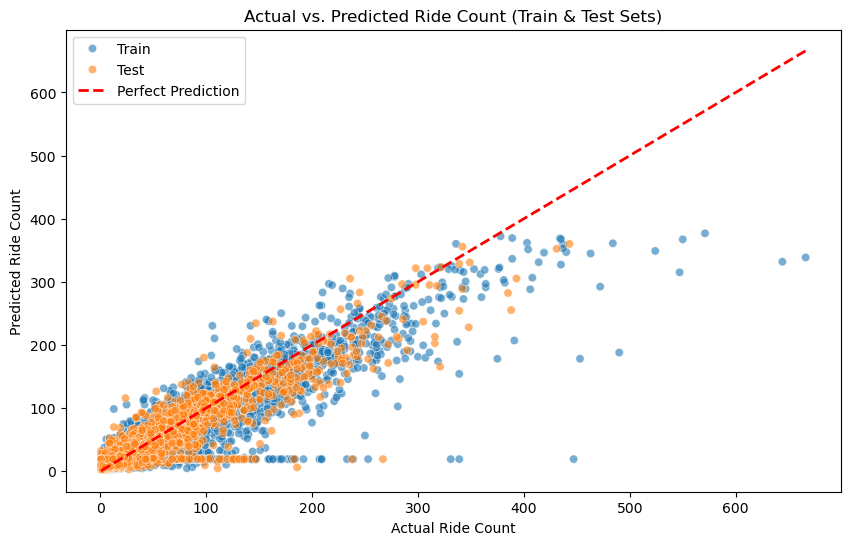

In [76]:
# Create a DataFrame for visualization
train_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred, 'Dataset': 'Train'})
test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Dataset': 'Test'})
plot_df = pd.concat([train_df, test_df])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='Actual', y='Predicted', hue='Dataset', alpha=0.6)
plt.plot([plot_df['Actual'].min(), plot_df['Actual'].max()], 
         [plot_df['Actual'].min(), plot_df['Actual'].max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Ride Count")
plt.ylabel("Predicted Ride Count")
plt.title("Actual vs. Predicted Ride Count (Train & Test Sets)")
plt.legend()
plt.show()

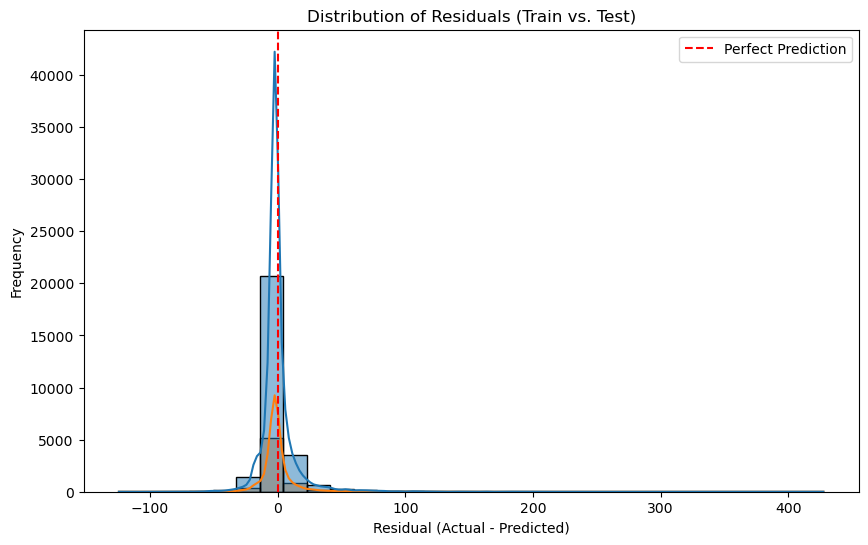

In [77]:
# Compute residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create DataFrame
residuals_df = pd.DataFrame({'Residuals': np.concatenate([train_residuals, test_residuals]),
                             'Dataset': ['Train'] * len(train_residuals) + ['Test'] * len(test_residuals)})

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=residuals_df, x='Residuals', hue='Dataset', kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Train vs. Test)")
plt.legend()
plt.show()

## Polynomial using Lag and Stratifed sample 

In [54]:
# Assuming your dataframe is named bike_hourly_new
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Extract day and additional features
stratified_sample['day'] = stratified_sample['started_at'].dt.date
stratified_sample['day_of_week'] = stratified_sample['started_at'].dt.dayofweek
stratified_sample['month'] = stratified_sample['started_at'].dt.month

# Group by day, rideable_type, start_station_name, day_of_week, and month to get ride counts
grouped = (stratified_sample.groupby(['day', 'rideable_type', 'start_station_name', 'day_of_week', 'month'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(7)
grouped['rolling_mean_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].transform(lambda x: x.rolling(window=7).mean())
grouped['is_weekend'] = grouped['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop NaN values
grouped.dropna(inplace=True)

# Define features and target
X6 = grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]
y6 = grouped['ride_count']

# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X6)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y6, test_size=0.2, random_state=42)

# Polynomial Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)
print(f"Mean Absolute Error (MAE): {mae}")

# # Display Actual vs Predicted Values
# comparison_df = pd.DataFrame({
#     'Actual Casual Trips': y_test.values,
#     'Predicted Casual Trips': y_pred
# })

# # Predict future trips
# grouped['predicted_rides'] = model.predict(poly.transform(grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]))

# # Get top 20 stations with the highest predicted rides
# top_20_predicted = (grouped.sort_values(['day', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
#                                 .groupby(['day', 'rideable_type'], observed=True)
#                                 .head(20)
#                                 .reset_index(drop=True))

# print(top_20_predicted.head())

Optimized Mean Squared Error (MSE) for Casual: 3.5759582336828757
Optimized R^2 Score for Casual: 0.7284456496475126
Mean Absolute Error (MAE): 2.8598333162504006


## Hyperparameter Tuning for RandomForest using GridSearchCV (Stratified + Lag)

In [55]:
# Convert 'started_at' to datetime if it's not already
bike_master_clean_2023['started_at'] = pd.to_datetime(bike_master_clean_2023['started_at'])

# Sample 20% of data while maintaining rideable_type distribution
stratified_sample, _ = train_test_split(bike_master_clean_2023, test_size=0.8, stratify=bike_master_clean_2023['rideable_type'], random_state=42)

# Extract day and additional features
stratified_sample['day'] = stratified_sample['started_at'].dt.date
stratified_sample['day_of_week'] = stratified_sample['started_at'].dt.dayofweek
stratified_sample['month'] = stratified_sample['started_at'].dt.month


# Group by day, rideable_type, start_station_name, day_of_week, and month to get ride counts
grouped = (stratified_sample.groupby(['day', 'rideable_type', 'start_station_name', 'day_of_week', 'month'], observed=True)
             .size()
             .reset_index(name='ride_count'))

# Feature engineering
# Adding lag features to capture historical trends
grouped['lag_1'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(1)
grouped['lag_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].shift(7)

# Rolling average to capture weekly trends
grouped['rolling_mean_7'] = grouped.groupby(['rideable_type', 'start_station_name'], observed=True)['ride_count'].transform(lambda x: x.rolling(window=7).mean())

# Weekend indicator
grouped['is_weekend'] = grouped['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop NaN values created by shifting and rolling averages
grouped.dropna(inplace=True)

# Define features and target
X5 = grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']]
y5 = grouped['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

# Grid Search CV for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=3,
                            verbose=1,
                            n_jobs=-1,
                            scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized Mean Squared Error (MSE) for Casual:", mse)
print(f"Optimized R^2 Score for Casual:", r2)
print(f"Mean Absolute Error (MAE): {mae}")


# # Display Actual vs Predicted Values
# comparison_df = pd.DataFrame({
#     'Actual Casual Trips': y_test.values,
#     'Predicted Casual Trips': y_pred
# })

# # Predict future trips
# grouped['predicted_rides'] = best_model.predict(grouped[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'is_weekend']])

# # Get top 20 stations with the highest predicted rides
# top_20_predicted = (grouped.sort_values(['day', 'rideable_type', 'predicted_rides'], ascending=[True, True, False])
#                                 .groupby(['day', 'rideable_type'], observed=True)
#                                 .head(20)
#                                 .reset_index(drop=True))

# print(top_20_predicted.head())

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Optimized Mean Squared Error (MSE) for Casual: 3.5669435467210575
Optimized R^2 Score for Casual: 0.7291302150986662
Mean Absolute Error (MAE): 2.8598333162504006


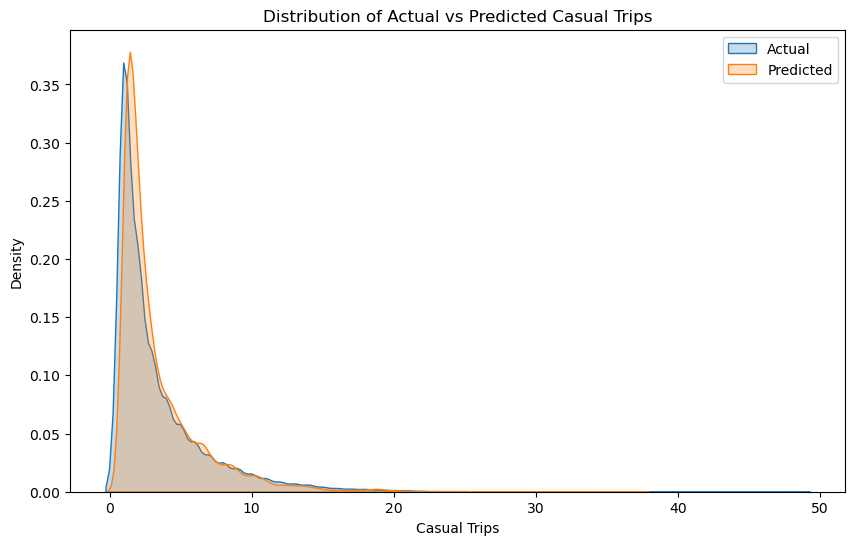

In [56]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True)   # Replaced shade=True with fill=True
sns.kdeplot(y_pred, label='Predicted', fill=True)

plt.xlabel('Casual Trips')
plt.title('Distribution of Actual vs Predicted Casual Trips')
plt.legend()
plt.show()